In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import copy

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np

In [36]:
imsize = 200

transform = transforms.Compose([
    transforms.Scale(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()
])

def ImageLoader(image):
    load = Image.open(image)
    tensor = Variable(transform(load))
    tensor = tensor.unsqueeze(0)
    return tensor
    
style_img = ImageLoader('Images/dancing.jpg')
content_img = ImageLoader('Images/picasso.jpg')

#style_img type(Variable) dimension # 1,3,128,128

assert(style_img.size()==content_img.size())

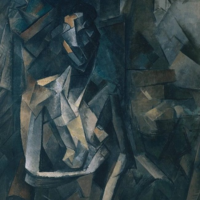

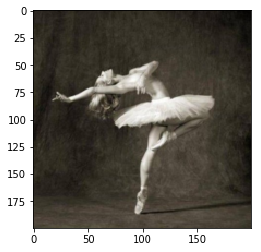

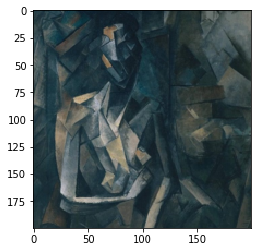

In [37]:
unloader = transforms.ToPILImage()
plt.ion()
def imshow(tensor,title=None):
    t = tensor.clone().cpu()
    t = t.view(3,imsize,imsize)
    t = unloader(t)

    plt.imshow(t)
    if title  is not None:
        plt.title(title)
    plt.pause(0.001)
    return t
    
plt.figure()
imshow(style_img.data)
plt.figure()
imshow(content_img.data)

In [8]:
class ContentLoss(nn.Module):
    def __init__(self,target,weight):
        super(ContentLoss,self).__init__()
        self.target = target.detach()*weight
        self.weight = weight
        self.criterion = nn.MSELoss()
    
    def forward(self,input):
        self.loss = self.criterion(input*self.weight,self.target)
        self.output = input
        return self.output
    
    def backward(self,retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [9]:
#STYLE LOSS 
class GramMatrix(nn.Module):
    def forward(self,input):
        a,b,c,d = input.size()
        features = input.view(a*b,c*d)
        G = torch.mm(features,features.t())
        return G.div(a*b*c*d) #change it to c*d
     
class StyleLoss(nn.Module):
    def __init__(self,target,weight):
        super(StyleLoss,self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
    
    def forward(self,input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G,self.target)
        return self.output
    
    def backward(self,retain_graph= True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [10]:
cnn = models.vgg19(pretrained = True).features


In [11]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1','conv_2','conv_3','conv_4','conv_5']

def get_style_model_and_losses(cnn,style_img,content_img,style_weight=1000,
                               content_weight=1,
                              content_layers=content_layers_default,
                              style_layers = style_layers_default):
    cnn = copy.deepcopy(cnn) #since we don't want out original cnn paramtetrs to be change
    #above cnn is refrencing in this scope only outside cnn has no link to this cnn now after copying
    
    content_losses=[]
    style_losses =[]
    
    model = nn.Sequential()
    gram = GramMatrix()
    
    i=1
    for layer in list(cnn):
        if isinstance(layer,nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name,layer)
            if name in content_layers:
                target = model(content_img).clone()
                #what would happend if not cloned
                content_loss = ContentLoss(target,content_weight)
                model.add_module("content_loss_" + str(i),content_loss)
                content_losses.append(content_loss)
                
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_features_gram = gram(target_feature)
                style_loss = StyleLoss(target_features_gram,style_weight)
                model.add_module("style_loss_"+str(i),style_loss)
                style_losses.append(style_loss)
        
        if isinstance(layer,nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name,layer)
            if name in content_layers:
                target = model(content_img).clone()
                #what would happend if not cloned
                content_loss = ContentLoss(target,content_weight)
                model.add_module("content_loss_" + str(i),content_loss)
                content_losses.append(content_loss)
                
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_features_gram = gram(target_feature)
                style_loss = StyleLoss(target_features_gram,style_weight)
                model.add_module("style_loss_"+str(i),style_loss)
                style_losses.append(style_loss)
        
            i+=1
            
        if isinstance(layer,nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name,layer) # ***
    return model,style_losses,content_losses           

In [12]:
#TESTING models and losses
model,s,c = get_style_model_and_losses(cnn,style_img,
                                      content_img,content_weight = 1)

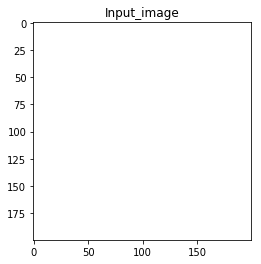

In [13]:
#input_Image 
# input_img = content_img.clone()
input_img = Variable(torch.ones(content_img.data.size()))
plt.figure()
t = imshow(input_img.data,title='Input_image')

In [14]:
def get_input_param_optimizer(input_img):
    input_param = nn.Parameter(input_img.data) #Here try to make it a Variable and then pass Variable to i
    optimizer = optim.LBFGS([input_param])
    return input_param,optimizer


In [42]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps: #Test change numsteps

        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
#             #test
#                 print(input_param.grad.data[0][0][0][0])
#             #test
            
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()
            variation_loss =  torch.sum(input_param[:,:,:-1,:] - input_param[:,:,1:,:]**2) +torch.sum(input_param[:,:,:,:-1]-input_param[:,:,:,1:]**2)

            return style_score + content_score + 0.001*variation_loss

        optimizer.step(closure)
        

    # a last correction...
    input_param.data.clamp_(0, 1)

    return input_param.data

In [ ]:
output = run_style_transfer(cnn, content_img, style_img, input_img,num_steps = 400)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.129774 Content Loss: 0.486008

run [100]:
Style Loss : 0.128749 Content Loss: 0.483352



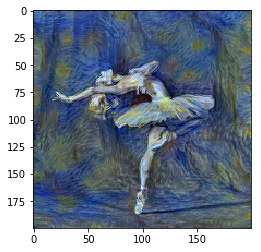

In [55]:
t = imshow(output)
t.save("OriginalImageGeneratedonZero.jpg")

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)


In [33]:
inputparam = torch.randn(1,2,2)


ValueError: result of slicing is an empty tensor

In [34]:
inputparam


(0 ,.,.) = 
  0.5715  0.0786
 -0.9615 -2.5467
[torch.FloatTensor of size 1x2x2]

In [35]:
inputparam[:-1,:,:] - inputparam[1:,:,:]**2

ValueError: result of slicing is an empty tensor